In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
%matplotlib inline

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
  parts = numbers.split(value)
  parts[1::2] = map(int, parts[1::2])
  return parts

In [3]:
def load_data(split=0.1):  
  images= sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainx/*.bmp'), key=numericalSort)
  masks = sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainy/*.bmp'), key=numericalSort)

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=101)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=101)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=101)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=101)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [4]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

In [5]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [6]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
    
  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y

In [7]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

In [9]:
def display(arrimg):
  plt.figure(figsize=(20,10))
  for i in range(len(arrimg)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(arrimg[i])
  plt.show()

In [10]:
def display_mask(arrimg):
  plt.figure(figsize=(20,10))
  for i in range(len(arrimg)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(arrimg[i], cmap='gray')
  plt.show()

In [11]:
# def iou(y_true, y_pred, smooth = 100):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#   sum_i = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
#   iou_val = (intersection + smooth) / (sum_i - intersection + smooth)
#   return iou_val

In [12]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [13]:
def dice_coeff(y_true, y_pred, smoothness = 100):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smoothness) / (K.sum(y_true_f) + K.sum(y_pred_f) + smoothness)

In [14]:
def precision(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [15]:
def recall(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

In [16]:
def accuracy(y_true, y_pred):    
  return K.mean(K.equal(y_true, K.round(y_pred)))

In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [18]:
def double_conv(x, num_filters):
  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  return x

In [19]:
def double_conv_transpose(x, num_filters):
  x = Conv2DTranspose(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [20]:
def UNET():
  size = 256
  num_filters = [64, 128, 256, 512, 1024]
  inputs = Input((size, size, 3))

  skip_x = []
  x = inputs

  for f in num_filters:
      x = double_conv(x, f)
      skip_x.append(x)
      x = MaxPool2D((2, 2))(x)

  x = double_conv(x, num_filters[-1])

  num_filters.reverse()
  skip_x.reverse()

  for i, f in enumerate(num_filters):
      x = UpSampling2D((2, 2))(x)
      xs = skip_x[i]
      x = Concatenate()([x, xs])
      x = double_conv(x, f)

  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)

  return Model(inputs, x)

In [21]:
model = UNET()
model.compile(optimizer= Adam(learning_rate=1e-4), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coeff, precision, recall, accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
batch = 8
epochs = 50
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [23]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [24]:
history = model.fit(train_dataset,
        validation_data=valid_dataset,        
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps      
        )

Epoch 1/50
20/20 [==============================] - 165s 6s/step - loss: 0.3645 - iou: 0.4888 - dice_coeff: 0.6492 - precision: 0.7916 - recall: 0.7779 - accuracy: 0.8486 - val_loss: 0.6439 - val_iou: 0.1906 - val_dice_coeff: 0.3184 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 2/50
20/20 [==============================] - 27s 1s/step - loss: 0.2522 - iou: 0.6066 - dice_coeff: 0.7519 - precision: 0.8653 - recall: 0.8492 - accuracy: 0.9025 - val_loss: 0.5712 - val_iou: 0.1945 - val_dice_coeff: 0.3241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 3/50
20/20 [==============================] - 27s 1s/step - loss: 0.2140 - iou: 0.6519 - dice_coeff: 0.7866 - precision: 0.8785 - recall: 0.8799 - accuracy: 0.9178 - val_loss: 0.5226 - val_iou: 0.1880 - val_dice_coeff: 0.3156 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 4/50
20/20 [==============================] - 27s 1s/step - loss: 0.2

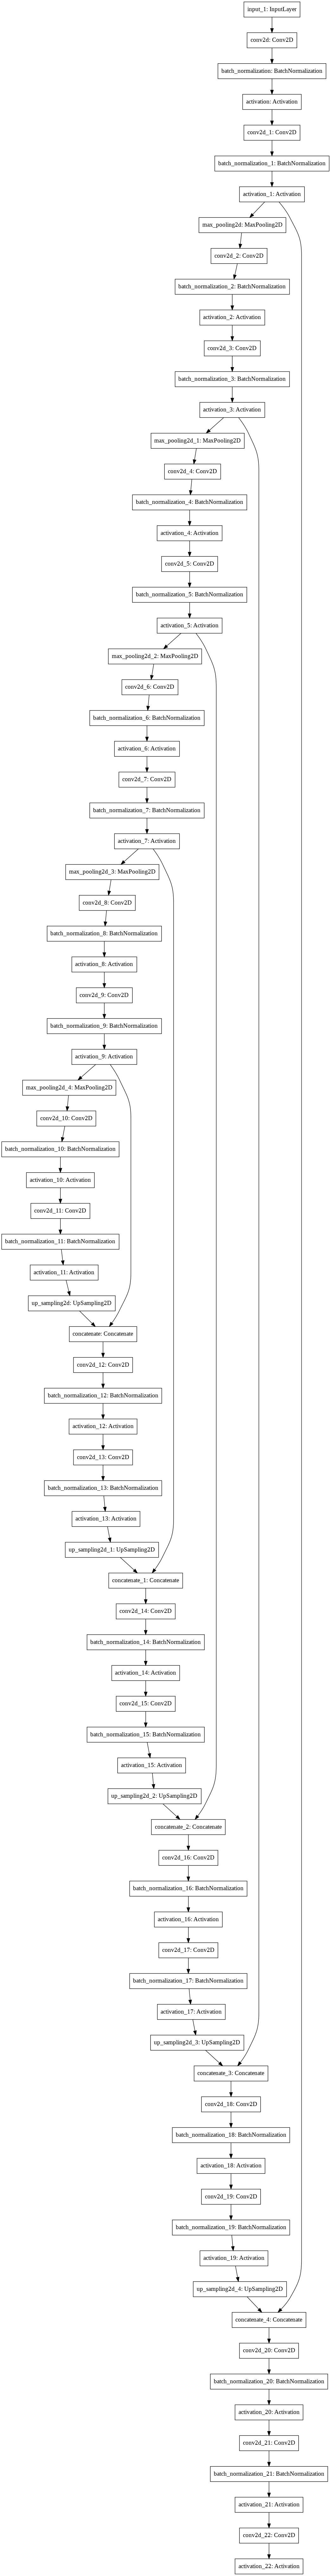

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

In [26]:
def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = np.expand_dims(x, axis=-1)
  return x

In [27]:
def display_new(no=0):
  x=test_x[no]
  y=test_y[no]
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  x_r = read_image(x)
  plt.imshow(x_r)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  y_r = read_image(y)
  plt.imshow(y_r)
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Predicted Image')
  x=read_image(x)
  y=read_mask(y)
  y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
  y_pred = mask_parse(y_pred) * 255.0
  y_pred = cv2.resize(y_pred, (256, 256))
  plt.imshow(y_pred, cmap='gray')
  plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


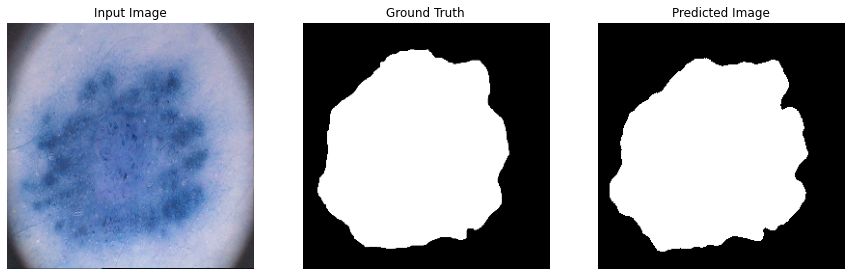

In [28]:
display_new(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


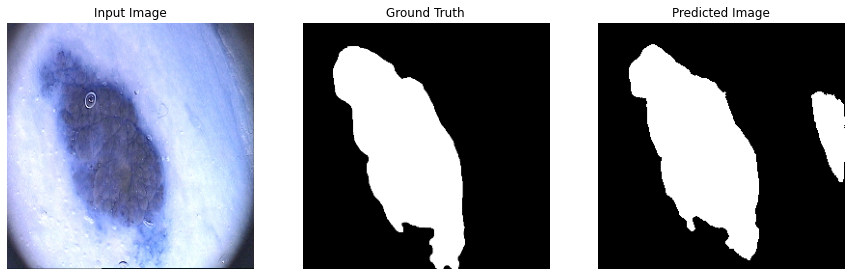

In [30]:
display_new(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


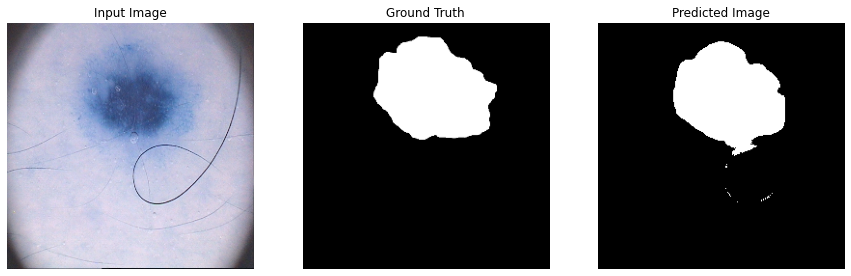

In [31]:
display_new(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


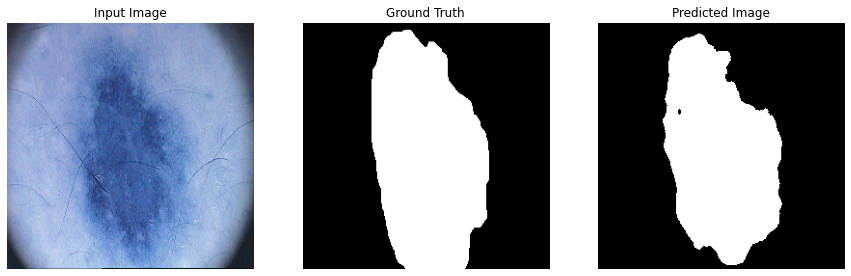

In [32]:
display_new(17)